## EDA
This notebook demonstrates the EDA process that I took when first evaluating the Tweets. It was `cleaned up` at the end, but contains several comments that preserve my approach. A summary of these steps can be found in the technical report notebook

--- 

**Library Imports**

In [1]:
# the classics
import scipy.sparse as sparse
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
%matplotlib inline

# import some pre-written snippets that might be useful.
from wbcustom.roc import plot as roc_plot
#from wbcustom.notebook_analysis import notebook_analysis as notebook

# some specific data manipulation tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# a few models to try at first
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

# model evaluation tools
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

**Reading in the Data**

In [2]:
# read in all of the tweets
tweets = pd.read_csv('./data/tweets.csv')

**Initial Inspection**

In [3]:
# quick look at what I'm dealing with
tweets.info()
tweets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 4 columns):
post_id                 22000 non-null object
text                    21930 non-null object
date_posted             22000 non-null object
questionable_content    22000 non-null int64
dtypes: int64(1), object(3)
memory usage: 687.6+ KB


,post_id,text,date_posted,questionable_content
0,0001c77a4801bb027d688e666563871f,RT @knowledgwharton: What's behind Apple's rec...,2012-04-18 19:36:01,0
1,000331a02f8139ed402aef6aa36e8082,"she escaped an abusive marriage, worked&payed ...",2016-07-18 06:20:01,0
2,0009cafe3525d848a2e559b1accb1146,Nigga this is outside,2017-06-01 21:06:58,1
3,00124caf4bb38d55fbdd48ded2411eda,GM takes on Ford Fiesta with the Chevy Sonic v...,2011-05-31 12:33:49,0
4,00133102dbc83e0ceb396abb7cd98886,"I want to give Tyrone a hug, a drink, and even...",2017-04-05 06:13:19,0


22,000 tweets, 4 columns in total:
 - post_id: a unique post id (not the numeric status id from twitter)
 - text: the content of the tweet
 - date_posted: tweet's time-stamp (not in datetime format)
 - questionable_content: target column
 
We see that a few of our data points are missing their original content. Upon first inspection, I was hoping to retrieve the missing data using `python-twitter` and the post_id column, but the values are string identifiers, and not the numeric tweet ids. Next time...  

Let's check the balance of our target class.

In [4]:
cb = tweets['questionable_content'].value_counts()

print('Counts', cb.values)
print('Composition', cb.values/len(tweets))

Counts [19098  2902]
Composition [0.86809091 0.13190909]


2902 tweets are marked as questionable, meaning 13%. We will need to keep this slight imbalance in mind during modeling, but for now let's take a look at the 70 tweets that are missing text.

**Addressing the Missing Data**

In [5]:
# gather tweets with null values in the text column
null = tweets[tweets['text'].isnull()]

null.head()

,post_id,text,date_posted,questionable_content
128,019297edd8f89b2de4ad4815fb8a8b0a,NaN,2011-10-26 19:48:59,0
210,029fced8545582fec09e4c70d17d1039,NaN,2016-01-17 03:27:50,0
471,05acc5d09f7367495cd47fc3940168b5,NaN,2011-11-09 20:39:47,0
783,0967203fd1e0f9a814dfc0c027a8563d,NaN,2012-01-30 10:02:53,0
1285,0f2393dde2a33ca8fa75090ab0417101,NaN,2015-08-29 19:21:48,0


In [6]:
# what are the labels of the missing tweets?
null['questionable_content'].value_counts()

0    66
1     4
Name: questionable_content, dtype: int64

Some of them are labeled as questionable, but we can't hope to figure out why without the tweet's text or the ability to look up the original tweet itself. Dropping these tweets only removes .3% of our data, so I will go ahead and drop them.

In [7]:
# drop tweets with any null values
tweets = tweets.dropna().reset_index(drop=True)

**Quick Look at `date_posted`**

In [8]:
# convert the column to a datetime object, rename it to timestamp
try:
    tweets['timestamp'] = pd.to_datetime(tweets['date_posted'])    
    tweets = tweets.drop(columns='date_posted')
except KeyError:
    pass

# create columns with each time scale value
timestamp = pd.DataFrame({
    'hour': tweets['timestamp'].dt.hour,
    'day': tweets['timestamp'].dt.day,
    'month': tweets['timestamp'].dt.month,
    'year': tweets['timestamp'].dt.year,
    'day_of_week': tweets['timestamp'].dt.dayofweek,
    'week_of_year': tweets['timestamp'].dt.weekofyear
})

# add this new info to the data
tweets = pd.concat(objs=[tweets, timestamp], axis = 1)

Let's take a glance at the new columns

In [9]:
tweets.describe()

,questionable_content,hour,day,month,year,day_of_week,week_of_year
count,21930.000000,21930.000000,21930.000000,21930.000000,21930.000000,21930.000000,21930.000000
mean,0.132148,12.484086,15.792978,6.407159,2013.960876,2.846420,26.096261
std,0.338659,7.575244,8.791706,3.447180,4.286389,1.944423,15.047837
min,0.000000,0.000000,1.000000,1.000000,1970.000000,0.000000,1.000000
25%,0.000000,4.000000,8.000000,3.000000,2013.000000,1.000000,13.000000
50%,0.000000,15.000000,16.000000,6.000000,2015.000000,3.000000,26.000000
75%,0.000000,19.000000,23.000000,9.000000,2016.000000,4.000000,39.000000
max,1.000000,23.000000,31.000000,12.000000,2018.000000,6.000000,53.000000


In [10]:
set(tweets['year'])

{1970, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}

Some tweets are stamped with a 1970 post date. This is obviously an error as twitter wasn't created until 2006. Using the year 1970 as a mask, we can dig in to these erroneous timestamps.

In [11]:
tweets[tweets['year'] == 1970].describe()

,questionable_content,hour,day,month,year,day_of_week,week_of_year
count,156.000000,156.000000,156.000000,156.000000,156.0,156.000000,156.000000
mean,0.038462,13.615385,15.865385,5.762821,1970.0,3.102564,23.685897
std,0.192927,7.453479,9.189115,3.229126,0.0,1.944984,14.190776
min,0.000000,0.000000,1.000000,1.000000,1970.0,0.000000,2.000000
25%,0.000000,7.750000,6.750000,3.000000,1970.0,1.000000,12.000000
50%,0.000000,15.000000,16.500000,6.000000,1970.0,3.000000,23.500000
75%,0.000000,20.000000,24.000000,8.000000,1970.0,5.000000,34.000000
max,1.000000,23.000000,31.000000,12.000000,1970.0,6.000000,53.000000


It looks like these years are mislabled, but the rest of the timestamp is ok. We will avoid using the year in the model, knowing there are errors. Now lets plot out the count and questionable percentage of tweets on each time scale to look for any trends that exist. 

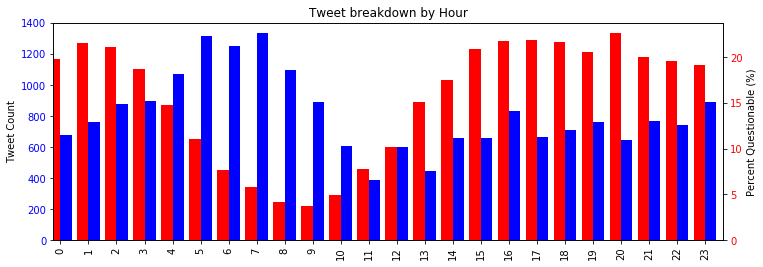

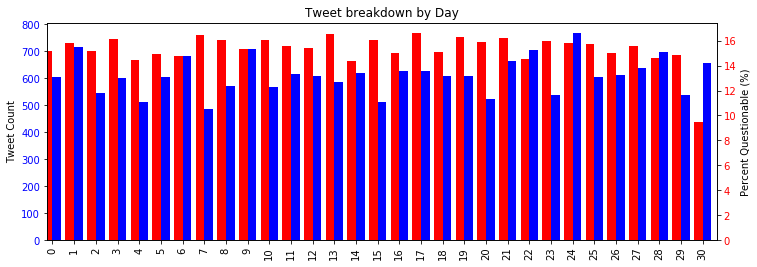

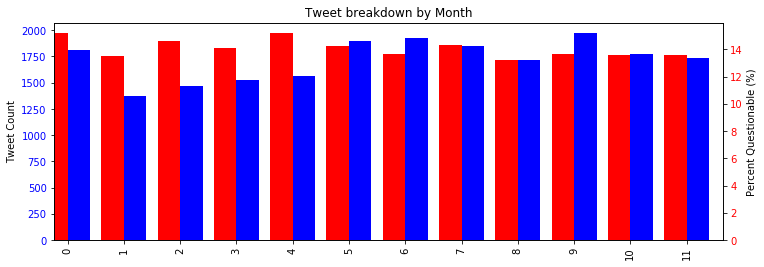

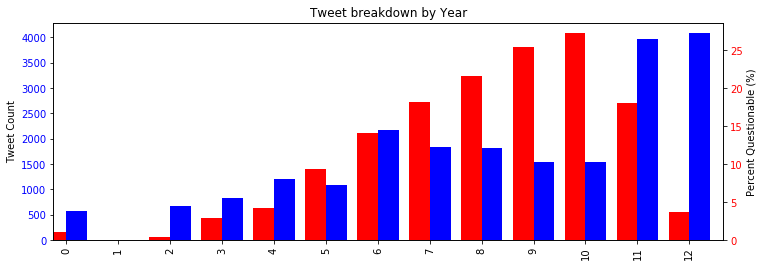

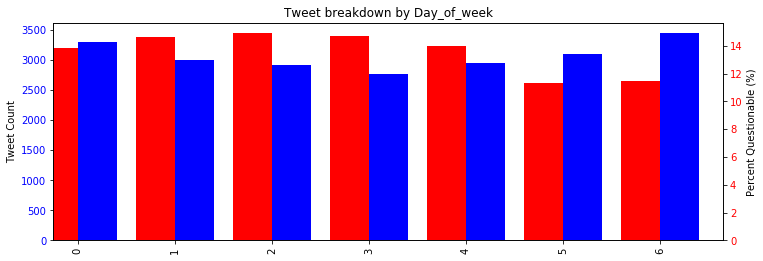

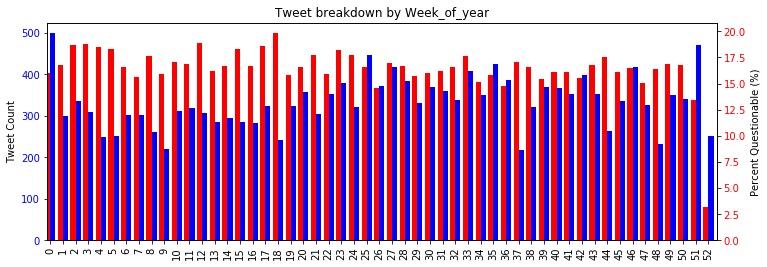

In [12]:
for column in ['hour', 'day', 'month', 'year', 'day_of_week', 'week_of_year']:
    
    # group tweets by different specified time scale
    groupings = tweets.groupby(by=[tweets[column]])

    # create the variables to plot: tweet counts, questionable content percentages, and time intervals
    y1 = list(groupings['questionable_content'].count())
    y2 = list(groupings['questionable_content'].sum()*100/groupings['questionable_content'].count())
    x = list(set(groupings.keys[0]))
    
    df = pd.DataFrame({
        'index': x,
        'count': y1,
        'questionable percentage': y2
    })
    
    # instantiate plot
    width= .4
    fig = plt.figure(figsize=(12,4)) # create figure
    
    # create the stacked subplots
    ax = fig.add_subplot(111) 
    ax2 = ax.twinx() # copy for side by side bars

    # use pandas to populate subplots
    df['count'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
    df['questionable percentage'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
    
    # set label and color for yticks for first plot
    ax.set_ylabel('Tweet Count')
    for tl in ax.get_yticklabels():
        tl.set_color('b')
    
    # again for second plot
    ax2.set_ylabel('Percent Questionable (%)',)
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
        
    # display final viz
    plt.title(f'Tweet breakdown by {column.capitalize()}')

These charts need to be cleaned up (specifically left spacing and xticks for by-year), but it gives us a quick look at the different trends. If these charts were required in production, I would likely use tableau to add tooltips. 

Some thoughts from looking at these plots:
- There appears to be a visual pattern in the hourly and day_of_week breakdowns. 
- There is an influx of tweets earlier in the day, with a lower proportion of questionable content being posted during that time. 
- Additionally, the percentage of questionable content has dropped off in the past two years despite a higher tweet counts.

Ultimately, we would need to dive in to the data collection methods, timestamps relative to user's timezone, etc., before this information would be more useful to us.

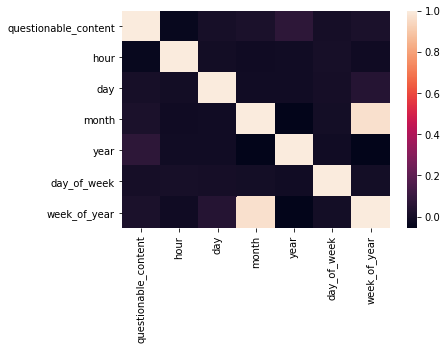

In [13]:
sns.heatmap(tweets.corr())

No real correlations with different time scales and label.

**Baseline Model**

Define the X and y variables, split them up into training and testing sets. Split maintains the class balance in the y variable.

In [14]:
X = tweets['text']
y = tweets['questionable_content']

# stratify on y variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state = 23)

Instantiate a stock count vectorizer to build a simple model based on word counts.

In [15]:
cvec = CountVectorizer()

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [16]:
# create a dataframe out of the vectorized test data
vec_feats = pd.DataFrame(X_test_cvec.todense(), columns = cvec.get_feature_names())

# inspect
vec_feats.head()

,00,000,00003,000th,001,003,006,007notabroadwaystar,00pm,01,...,सरक,イノベーションとは発明なのです,イノベーションは私たちがもう一度生み出さなければならないものです,イノベーションを通してしかチャンスはありません,マルゲリ氏,上海,兢兢占占,凯德龙之梦,吉原店,新加坡
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will want to scrub the non-english tweets later on as well.

Lets create a few different models and see how they do. Use the `%%time` magic command to get some efficiency info.

In [17]:
%%time
rfc = RandomForestClassifier(random_state = 23, n_estimators=50)
rfc.fit(X_train_cvec, y_train)

CPU times: user 8.84 s, sys: 25.3 ms, total: 8.87 s
Wall time: 8.87 s


In [18]:
print('Train Score: ', rfc.score(X_train_cvec, y_train))
print('Test Score: ', rfc.score(X_test_cvec, y_test))

Train Score:  0.9984799659512373
Test Score:  0.9337953674995441


After 2 seconds, we get a fairly 'accurate' model, but we aren't concerned with accuracy. Since we are trying to limit false negatives, we want to maximize recall. Let's dig deeper.  

In [19]:
# use the classification report function for more classification metrics
print(classification_report(y_test, rfc.predict(X_test_cvec)))
print('---')
confusion_matrix(y_test, rfc.predict(X_test_cvec))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4758
           1       0.90      0.57      0.69       725

   micro avg       0.93      0.93      0.93      5483
   macro avg       0.92      0.78      0.83      5483
weighted avg       0.93      0.93      0.93      5483

---


array([[4710,   48],
       [ 315,  410]])

Recall of .57 means we are only correctly questionable tweets 57% of the time. We can do better. As we see in the confusion matrix, 315 of the 725 questionable tweets in the test set were incorrectly labled as not questionable.

Let's see what our model is using to predict.

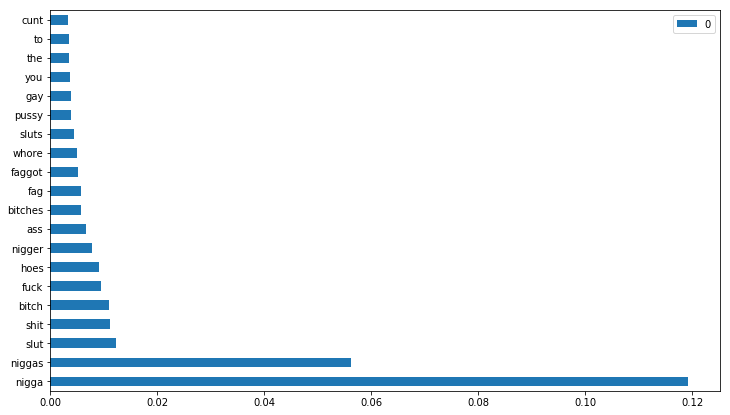

In [20]:
# get feature importances from the model, plot
pd.DataFrame(
    rfc.feature_importances_, 
    index=cvec.get_feature_names()
).sort_values(by=0, ascending=False).head(20).plot(kind='barh', figsize=(12,7))

The presence of common curse words and racial slurs are good indicators of a questionable tweet. Now a boosted model, to see if we can avoid the RFC's overfitting and improve sensitivity. 

In [21]:
%%time
abc = AdaBoostClassifier(n_estimators=50)
abc.fit(X_train_cvec, y_train)

CPU times: user 870 ms, sys: 5.7 ms, total: 876 ms
Wall time: 875 ms


In [22]:
print(classification_report(y_test, abc.predict(X_test_cvec)))
print('---')
confusion_matrix(y_test, abc.predict(X_test_cvec))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4758
           1       0.92      0.57      0.70       725

   micro avg       0.94      0.94      0.94      5483
   macro avg       0.93      0.78      0.83      5483
weighted avg       0.94      0.94      0.93      5483

---


array([[4722,   36],
       [ 315,  410]])

Better accuracy, same recall, fit time was 1/10th the RandomForest's. 

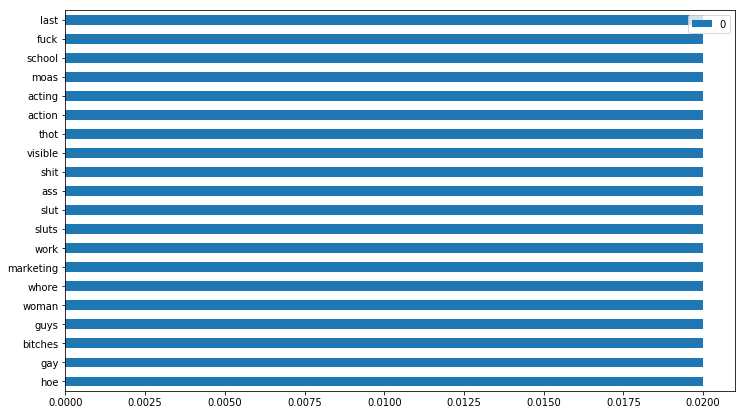

In [23]:
pd.DataFrame(abc.feature_importances_, index=cvec.get_feature_names()).sort_values(by=0, ascending=False).head(20).plot(kind='barh', figsize=(12,7))

Similar features, we will use this info for our feature engineering. We will now plot a roc curve to check if playing with our probability thresholds can help us tune.

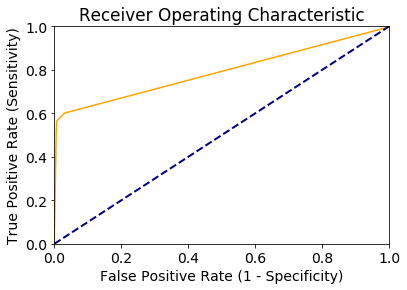

0.9283726433361733

In [25]:
# custom roc curve function (need to add auc score)
roc_plot(abc.predict_proba(X_test_cvec), y_test)
roc_auc_score(abc.predict(X_test_cvec), y_test)

This curve shows that we have a steep false positive slope, meaning we will get dramatically more false positives as we tune the probability threshold for recall (sensitivity). In our context, we don't mind more tweets to review if it means less get through the filter. 

Now that we have a grip on what is going on, let's dive in to some [feature engineering and modeling](./Data-Prep-and-Feature-Extraction.ipynb)